[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/graphviper/blob/main/docs/graph_building_tutorial.ipynb)

# GraphVIPER Tutorial

This tutorial provides examples of how `GraphVIPER` can be used to build [Dask](https://www.dask.org/) graphs by mapping a dictionary-based container of [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to [Dask](https://www.dask.org/) graph nodes, followed by a reduction step. The dictionary of [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) used in this tutorial is referred to as a [Processing Set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/_processing_set.py), although any dictionary containing [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) can be used. Using the `GraphVIPER` [map](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/map/index.html#module-contents) and [reduce](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/reduce/index.html#module-contents) functions can be thought of as a generalization of [xarray.map_blocks](https://docs.xarray.dev/en/stable/generated/xarray.map_blocks.html) that can be applied to more than one [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). Both [map](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/map/index.html#module-contents) and [reduce](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/reduce/index.html#module-contents) build [Dask](https://www.dask.org/) graphs using [dask.delayed](https://docs.dask.org/en/stable/delayed.html).

The following types of mapping are supported:

- Partitions defined by any combination of the coordinates in the [Processing Set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/_processing_set.py).
- More than one [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) can be assigned to a single mapping node.
- [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) partitions assigned to different nodes can have coordinates that overlap.

The tutorial will cover the following examples:

- Frequency Map Reduce: This example explains the concepts of `parallel_coords` and `node_task_data_mapping` that define parallelism.
- Overlapping Frequency Map Reduce.
- Baseline and Frequency Map Reduce.
- Time Map Reduce.

`GraphVIPER` provides improvements over the [CNGI prototype](https://cngi-prototype.readthedocs.io/en/stable/development.html):

- There is a clear separation between the concurrency layer ([GraphVIPER](https://graphviper.readthedocs.io/en/latest/)) and the domain layer (science code, [AstroVIPER](https://github.com/casangi/astroviper)).
- The memory backpressure issue was solved by incorporating the loading of data into the compute nodes. An example of the memory backpressure issue is cube imaging where large in-memory image cubes have to be created, which [Dask](https://www.dask.org/) is not aware of, causing [Dask](https://www.dask.org/) to be overeager in loading data from disk into memory. In the future, [Dask](https://www.dask.org/) might provide an alternative solution where graph nodes can be annotated with expected memory usage.
- The number of graph nodes has been minimized; this was also solved by incorporating the loading of data into the compute nodes. When [Xarray](https://docs.xarray.dev/) backed [Dask](https://www.dask.org/) datasets are used, a node is created for each data variable, and since Radio Astronomy datasets have numerous data variables, it led to a bloated graph that impacted scaling performance.
- Multiple [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) can be processed together with overlap. This cannot be done with the current [Xarray](https://docs.xarray.dev/) functionality, such as [xarray.map_blocks](https://docs.xarray.dev/en/stable/generated/xarray.map_blocks.html).
- Using a [Dask plugin](https://distributed.dask.org/en/latest/plugins.html), the [Dask Scheduler](https://docs.dask.org/en/stable/scheduler-overview.html) has been modified so that data can be cached to a local disk when multiple passes over larger-than-memory data have to be done. This reduces clustered file system or binary object store access (see [GraphVIPER Client](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/dask/client/index.html)).


## Install GraphVIPER

import os

from importlib.metadata import version

try:
    import graphviper

    print("GraphVIPER version", version("graphviper"), "already installed.")
except ImportError as e:
    print(e)
    print("Installing GraphVIPER")

    os.system("pip install graphviper")

    import graphviper

    print("GraphVIPER version", version("graphviper"), " installed.")

In [1]:
!python -m pip install -e .. >> /dev/null

## Setup Dask Cluster
To simplify things we are going to start of by just using a single process (everything will run in serial).

In [2]:
# Code to start a Dask cluster with two workers and 1 thread each.
from graphviper.dask.client import local_client
viper_client = local_client(cores=2, memory_limit="4GB",autorestrictor=True)
viper_client


#import dask
#dask.config.set(scheduler="synchronous")

[2024-02-29 11:33:52,943]     INFO  graphviper:  Checking parameter values for client.local_client 
[2024-02-29 11:33:52,943]     INFO      logger:  /export/home/ajax/jhoskins/Development/graphviper-serial-logging/ 
[2024-02-29 11:33:52,944]     INFO  graphviper:  Searching /export/home/ajax/jhoskins/Development/graphviper-serial-logging/src/graphviper/config/ for configuration file, please wait ... 
[2024-02-29 11:33:52,949]  WARNING  graphviper:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2024-02-29 11:33:54,586]     INFO  graphviper:  Created client <MenrvaClient: 'tcp://127.0.0.1:35329' processes=2 threads=2, memory=7.45 GiB> 


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35329,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:46389,Total threads: 1
Dashboard: http://127.0.0.1:35017/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:38653,


## Download and Convert Dataset

In [3]:
from graphviper.utils.data import download

download(file="Antennae_North.cal.lsrk.split.ms")

from xradio.vis.convert_msv2_to_processing_set import convert_msv2_to_processing_set

# The chunksize on disk. Chunksize can be specified for any of the following dimensions :
# time, baseline_id (interferometer) / antenna_id (single dish), frequency, and polarization.
chunks_on_disk = {"frequency": 3}
infile = "Antennae_North.cal.lsrk.split.ms"
outfile = "Antennae_North.cal.lsrk.split.vis.zarr"
convert_msv2_to_processing_set(
    in_file=infile,
    out_file=outfile,
    parallel=False,
    overwrite=True,
    main_chunksize=chunks_on_disk,
)

[2024-02-29 11:33:54,630]     INFO  graphviper:  File exists: Antennae_North.cal.lsrk.split.ms 


## Inspect the Processing Set

The [read_processing_set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/read_processing_set.py) is a lazy function, so no data is loaded into memory; only metadata is loaded (the [load_processing_set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/load_processing_set.py) will load everything into memory). Metadata is defined as everything that is not an [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html). Note that a [Processing Set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/_processing_set.py) does not have to be used with `GraphVIPER`, and any dictionary of [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) can be used.

In [4]:
import pandas as pd

pd.options.display.max_colwidth = 100
ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"

from xradio.vis.read_processing_set import read_processing_set

intents = ["OBSERVE_TARGET#ON_SOURCE"]
fields = None
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=intents,
    fields=fields,
)
display(ps.summary())

,name,ddi,intent,field_id,field_name,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_0,0,OBSERVE_TARGET#ON_SOURCE,0,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2,0,OBSERVE_TARGET#ON_SOURCE,2,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
2,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_1,0,OBSERVE_TARGET#ON_SOURCE,1,NGC4038 - Antennae North,3.439281e+11,3.440067e+11


## Inspect a single MS v4

The [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) within a Processing Set are called [Measurement Set v4](https://docs.google.com/spreadsheets/d/14a6qMap9M5r_vjpLnaBKxsR9TF4azN5LVdOxLacOX-s/edit?usp=sharing) (MS v4).

In [5]:
ms_xds = ps[
    "Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_0"
]
ms_xds

<xarray.Dataset>
Dimensions:                     (time: 45, baseline_id: 64, frequency: 8,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (baseline_id) int32 dask.array<chunksize=(64,), meta=np.ndarray>
    baseline_antenna2_id        (baseline_id) int32 dask.array<chunksize=(64,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 0 1 2 3 4 ... 59 60 61 62 63
  * frequency                   (frequency) float64 3.439e+11 ... 3.44e+11
  * polarization                (polarization) <U2 'XX' 'YY'
  * time                        (time) float64 1.307e+09 1.307e+09 ... 1.307e+09
  * uvw_label                   (uvw_label) <U1 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 dask.array<chunksize=(45, 64), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 dask.array<chunksize=(45, 64), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 dask.array<chunksize=(45, 64, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
Attributes:
    data_groups:   {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'VIS...
    ddi:           0
    field_info:    {'code': 'none', 'delay_direction': {'attrs': {'frame': 'F...
    intent:        OBSERVE_TARGET#ON_SOURCE
    antenna_xds:   <xarray.Dataset>\nDimensions:        (antenna_id: 15, xyz_...
    pointing_xds:  <xarray.Dataset>\nDimensions:  ()\nData variables:\n    *e...
    weather_xds:   <xarray.Dataset>\nDimensions:         (station_id: 2, time...

## Nomenclature

- `input_data`: A dictionary of [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) or a [processing_set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/_processing_set.py).
- `n_datasets`: The number of [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) in the input_data.
- `i_dim`: The $\text{i}^{\text{th}}$ dimension name.
- `n_dims`: The number of dimensions over which parallelism will occur.
- `n_dim_i_chunks`: Number of chunks into which the dimension coordinate `dim_i` has been divided.
- `n_nodes`: Number of nodes in the mapping stage of a MapReduce graph.
- `_{}`: If curly brackets are preceded by an underscore, it indicates a subscript and not a dictionary value.

## How Graph Parallelism is Specified: ```parallel_coords```

The `parallel_coords` is a dictionary where the keys are dimensions over which parallelism will occur and can be any of the dimension coordinate names present in the input data. For the `MS v4` [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), the options include time, baseline_id (interferometer) / antenna_id (single dish), frequency, and polarization. Each dimension coordinate name is associated with a dictionary that describes the data selection for that dimension in each node of the mapping stage of the graph.

The structure of the `parallel_coordinates`:
```
        parallel_coords = {
            dim_0: {
                'data': 1D list/np.ndarray of Number,
                'data_chunks': {
                    0 : 1D list/np.ndarray of Number,
                    ⋮
                    n_dim_0_chunks-1 : ...,
                }
                'data_chunk_edges': 1D list/np.ndarray of Number,
                'dims': (dim_0,), 
                'attrs': measure attribute,
            }
            ⋮
            dim_{n_dims-1}: ...
        }
```

The `dim_i` dictionaries keys have the following meanings:

- `data`: An array containing all the coordinate values associated with that dimension. These values do not necessarily have to match the values in the coordinates of the input data, as those are interpolated onto these values. The minimum and maximum values can be respectively larger or smaller than the values in the coordinates of individual [xarray.Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html); this will simply exclude that data from being processed. It's important to note that the `parallel_coords` and the input data coordinates must have the same measures attributes (reference frame, units, etc.).
- `data_chunks`: A dictionary where the values are chunks of the data and the keys are integers. This chunking determines the parallelism of the graph. The values in the chunks can overlap.
- `data_chunks_edges`: An array with the start and end values of each chunk.
- `dims`: The dimension coordinate name.
- `attrs`: The `XRADIO` measures attributes of the data (refer to [XRADIO documentation](https://docs.google.com/spreadsheets/d/14a6qMap9M5r_vjpLnaBKxsR9TF4azN5LVdOxLacOX-s/edit#gid=1504318014)).

The combinations of all the chunks in `parallel_coords` determine the parallelism of the graph. For example, if you have `parallel_coords` with 5 `time` and 3 `frequency` chunks, you would have 15-way parallelism (5x3).

This description may seem somewhat convoluted, but the following examples should help clarify things.

## Frequency Map Reduce

### Create Parallel Coordinates

GraphVIPER offers a convenient function, [make_parallel_coord](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/coordinate_utils/index.html#graphviper.graph_tools.coordinate_utils.make_parallel_coord), that converts any [XRADIO measures](https://docs.google.com/spreadsheets/d/14a6qMap9M5r_vjpLnaBKxsR9TF4azN5LVdOxLacOX-s/edit#gid=1504318014) to a `parallel_coord`. In this case, we will use the frequency coordinate of one of the datasets in the [processing_set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/_processing_set.py). It's worth noting that all datasets in this [processing_set](https://github.com/casangi/xradio/blob/main/src/xradio/vis/_processing_set.py) have the same frequency coordinates but differing time coordinates. This is the case because they represent the same spectral window but different fields in a Mosaic observation.

In [6]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = 3
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

The display of the frequency `parallel_coords` clearly shows how the data was split into 3 chunks. All the chunks must have the same number of values, except the last chunk, which can have fewer. `GraphVIPER` also has a convenience functions that can create [frequency](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/coordinate_utils/index.html#graphviper.graph_tools.coordinate_utils.make_frequency_coord) and [time](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/coordinate_utils/index.html#graphviper.graph_tools.coordinate_utils.make_time_coord) coordinate measures:

In [7]:
from graphviper.graph_tools.coordinate_utils import make_frequency_coord

n_chunks = 3

coord = make_frequency_coord(
    freq_start=343928096685.9587,
    freq_delta=11231488.981445312,
    n_channels=8,
    velocity_frame="lsrk",
)
parallel_coords["frequency"] = make_parallel_coord(
    coord=coord, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

### Create Node Task Data Mapping

Now, the coordinates in the input data must be mapped onto the `parallel_coords`. This is achieved using the `interpolate_data_coords_onto_parallel_coords` function, which produces the `node_task_data_mapping`. It is a dictionary where each key is a node id of one of the nodes in the mapping stage of the graph.

Structure of  node_task_data_mapping:
```
    node_task_data_mapping = {
        0 : {
            'chunk_indices': tuple of int,
            'parallel_dims': (dim_0, ..., dim_{n_dims-1}),
            'data_selection': {
                    dataset_name_0: {
                            dim_0: slice,
                            ⋮
                            dim_(n_dims-1): slice
                    }
                    ⋮
                    dataset_name_{n_dataset-1}: ...
            }
            'task_coords': 
                dim_0:{
                    'data': list/np.ndarray of Number,
                    'dims': str,
                    'attrs': measure attribute,
                }
                ⋮
                dim_(n_dims-1): ...
            }
        ⋮
        n_nodes-1 : ...
    }
```

Each `node_id` dictionary has the keys with the following meaning:

- `chunk_indices`: The indices assigned to the data chunks in the `parallel_coords`. There must be an index for each `parallel_dims`.
- `parallel_dims`: The dimension coordinates over which parallelism will occur.
- `data_selection`: A dictionary where the keys are the names of the datasets in the `processing_set`, and the values are dictionaries with the coordinates and accompanying slices. If a coordinate is not included, all values will be selected.
- `task_coords`: The chunk of the parallel_coord that is assigned to this node.

In [8]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Create a chunk function and map graph

The [map](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/map/index.html#graphviper.graph_tools.map.map) function combines a `node_task_data_mapping` and a `node_task` to create the map portion of the graph. The `node_task` must be a function with a single dictionary input and a single output as is the `my_func` in the example below. The `map` function will pass the `input_params` dictionary to the `node_task` and add the following items from the `node_task_data_mapping`:

- chunk_indices
- parallel_dims
- data_selection
- task_coords
- task_id

If local caching is enabled the following will also be included with the `input_params` dictionary:

- date_time
- viper_local_dir

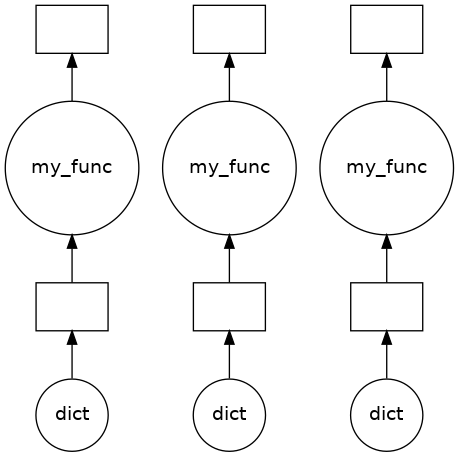

In [9]:
from graphviper.graph_tools.map import map
import dask
from graphviper.utils.display import dict_to_html
from IPython.display import display, HTML


def my_func(input_params):
    display(HTML(dict_to_html(input_params)))

    print("*" * 30)
    return input_params["test_input"]


input_params = {}
input_params["test_input"] = 42

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_params=input_params,
)

dask.visualize(graph, filename="map_graph")

In [10]:
graph

([Delayed('my_func-28db2b18-806a-4d87-b33f-1a8b88d90a0d'),
  Delayed('my_func-ef9f5dd6-698f-4158-97be-5cc82ed65bcc'),
  Delayed('my_func-bdd6e74e-d79b-4214-95f2-4d719ecfc6bb')],
 None)

### Run Map Graph

In [11]:
dask.compute(graph)

(([42, 42, 42], None),)

### Reduce Graph
The [reduce](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/reduce/index.html#graphviper.graph_tools.reduce.reduce) function takes the graph created by the [map](https://graphviper.readthedocs.io/en/latest/_api/autoapi/graphviper/graph_tools/map/index.html#graphviper.graph_tools.map.map) function and adds a reduce graph that combines the outputs using one of two methods:

- `single_node`: where the output from all `map` nodes is sent to a single node,
- `tree`: where the outputs are combined using a binary tree reduction.

The function that forms the nodes in the reduce portion of the graph must have two parameters: ``input_data`` and ``input_params``. The ``input_data`` represents the output from the mapping nodes, while ``input_params`` comes from the ``reduce`` parameter with the same name.

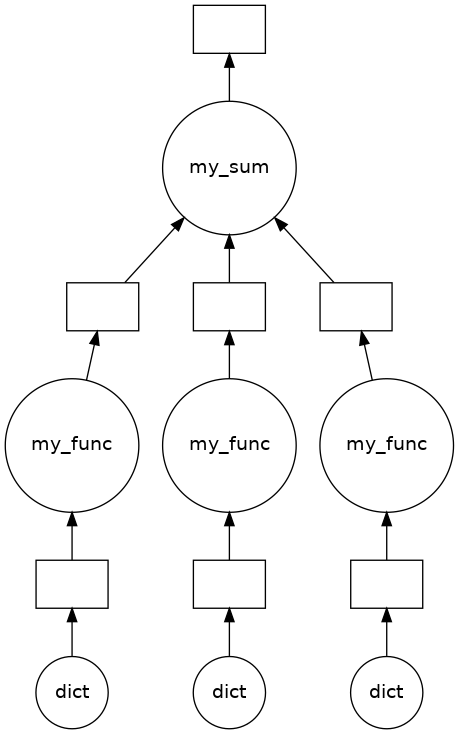

In [12]:
# Single Node Reduce
from graphviper.graph_tools import reduce
import numpy as np


def my_sum(graph_inputs, input_params):
    print(graph_inputs)
    return np.sum(graph_inputs / input_params["test_input"])


input_params = {}
input_params["test_input"] = 5
graph_reduce = reduce(
    graph, my_sum, input_params, mode="single_node"
)  # mode "tree","single_node"
dask.visualize(graph_reduce)

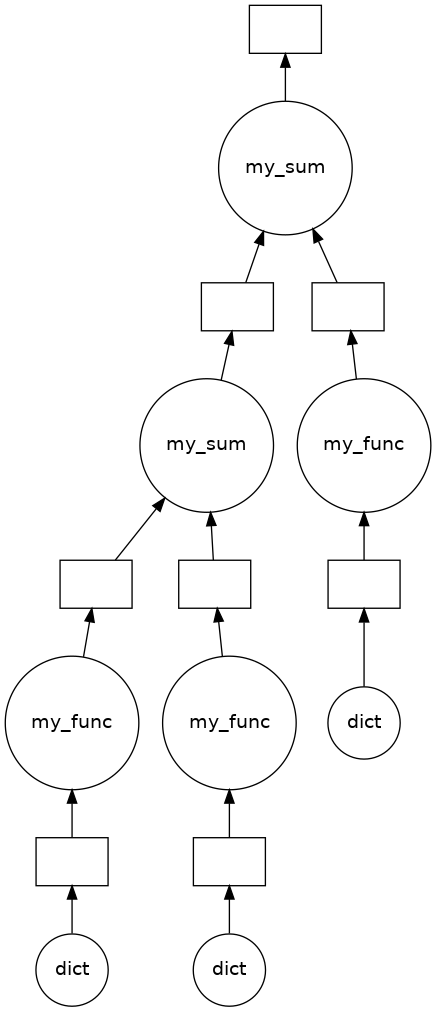

In [13]:
# Tree Reduce
from graphviper.graph_tools import reduce
import numpy as np


def my_sum(graph_inputs, input_params):
    print(graph_inputs)
    return np.sum(graph_inputs) + input_params["test_input"]


input_params = {}
input_params["test_input"] = 5
graph_reduce = reduce(
    graph, my_sum, input_params, mode="tree"
)  # mode "tree","single_node"
dask.visualize(graph_reduce)

### Run Map Reduce Graph

In [14]:
dask.compute(graph_reduce)

([[136], None],)

## Overlapping Frequency Map Reduce

### Create Parallel Coordinates

In [15]:
from graphviper.utils.display import dict_to_html
import dask

dask.config.set(scheduler="synchronous")
from xradio.vis.read_processing_set import read_processing_set
from IPython.display import HTML, display


ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)
n_chunks = 3

parallel_coords = {}
freq_coord = ms_xds.frequency.to_dict()
# Here, we create overlapping data chunks. Currently, there is no convenience function available to assist with this.
freq_coord["data_chunks"] = {
    0: freq_coord["data"][0:4],
    1: freq_coord["data"][3:7],
    2: freq_coord["data"][4:8],
}
parallel_coords["frequency"] = freq_coord

display(HTML(dict_to_html(parallel_coords["frequency"])))

### Create Node Task Data Mapping

In [16]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Map Graph

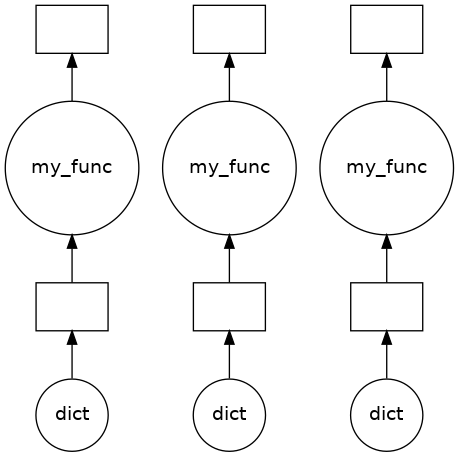

In [17]:
from graphviper.graph_tools.map import map
import dask
from IPython.display import display, HTML
from xradio.vis.read_processing_set import read_processing_set


def my_func(input_params):
    display(HTML(dict_to_html(input_params)))

    print("*" * 30)
    return input_params["test_input"]


input_params = {}
input_params["test_input"] = 42

ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_params=input_params,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [18]:
dask.compute(graph)

/export/home/ajax/jhoskins/.conda/envs/python-3.10/lib/python3.10/site-packages/dask/base.py:1525: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


******************************


******************************


******************************


(([42, 42, 42], None),)

## Baseline and Frequency Map Reduce

### Create Parallel Coordinates

In [19]:
from graphviper.utils.display import dict_to_html
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set

from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

parallel_coords = {}

import xarray as xr
import numpy as np

n_chunks = 4
parallel_coords["baseline_id"] = make_parallel_coord(
    coord=ms_xds.baseline_id, n_chunks=n_chunks
)

n_chunks = 3
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)

display(HTML(dict_to_html(parallel_coords)))

### Create Node Task Data Mapping

In [20]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Map Graph

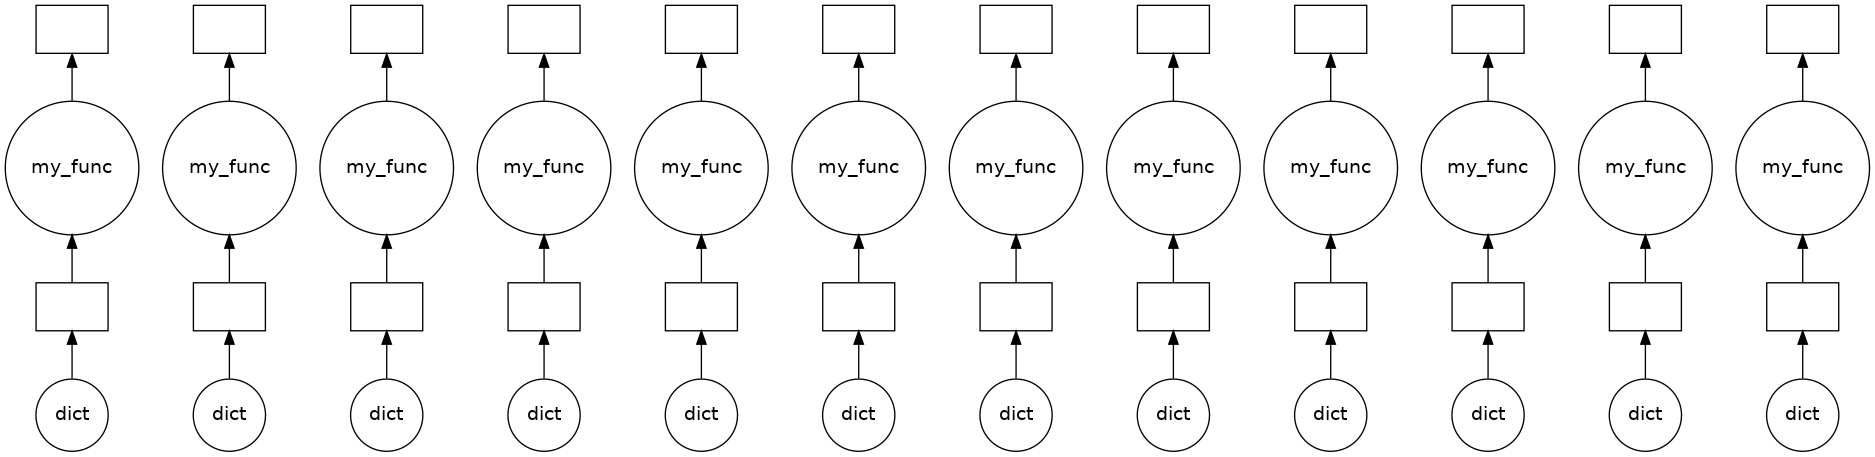

In [21]:
from graphviper.graph_tools.map import map
import dask
from IPython.display import display, HTML


def my_func(input_params):
    display(HTML(dict_to_html(input_params)))

    print("*" * 30)
    return input_params["test_input"]


# ['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_params = {}
input_params["test_input"] = 42

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_params=input_params,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [22]:
dask.compute(graph)

/export/home/ajax/jhoskins/.conda/envs/python-3.10/lib/python3.10/site-packages/dask/base.py:1525: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


(([42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42], None),)

## Time Map Reduce

### Create Parallel Coordinates

In [23]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set
from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

parallel_coords = {}

import xarray as xr
import numpy as np

t0, t1, t2 = (ps.get(1).time, ps.get(0).time, ps.get(2).time)
time_coord = xr.concat([t0, t1, t2], dim="time").sortby("time").to_dict()
n_chunks = 4
parallel_coords["time"] = make_parallel_coord(coord=time_coord, n_chunks=n_chunks)
display(HTML(dict_to_html(parallel_coords["time"])))

### Create Node Task Data Mapping

In [24]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Map Graph

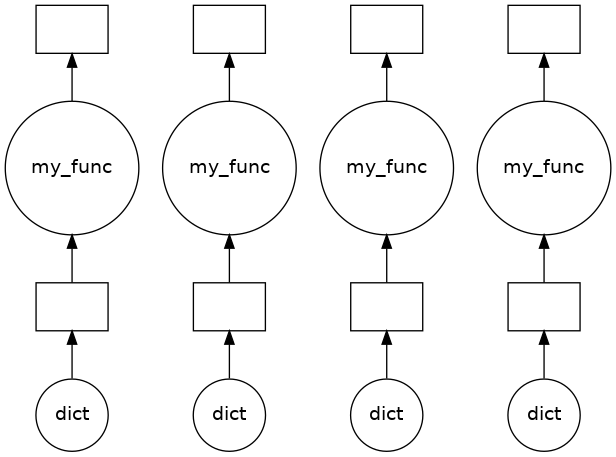

In [25]:
from graphviper.graph_tools.map import map
import dask
from IPython.display import display, HTML


def my_func(input_params):
    display(HTML(dict_to_html(input_params)))

    print("*" * 30)
    return input_params["test_input"]


# ['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_params = {}
input_params["test_input"] = 42

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_params=input_params,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [26]:
dask.compute(graph)

/export/home/ajax/jhoskins/.conda/envs/python-3.10/lib/python3.10/site-packages/dask/base.py:1525: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


******************************


******************************


******************************


******************************


(([42, 42, 42, 42], None),)